<img src="media/logo.jpg" width="300">

# Master 2 VMI - TP RF : Convolutionnal Neural Network (CNN) 

Prérequis pour ce TP : disposer d'un compte Google
* Télécharger ce projet GitHub sur votre machine locale
* Uploader ensuite ce projet dans un dossier lié à votre compte Google Drive
* Ouvrir Google Collab et rechercher votre projet
* Vous pouvez alors exécuter les différentes étapes sucessivement de ce notebook en local sur le serveur Google Collab, ce qui vous évite de disposer d'un GPU en local

## La classification
La classification est un precessus qui prend une entrée une donnée (par exemple, une image et ses pixels) et qui repond par une decision en sortie (chien, chat, ...) ou la probabiltée de chacune des classes considérées.

## Les réseaux de neurones convolutionnels (CNN)
Les CNN sont des réseaux profonds composés de différentes couches dans le but d'extraire (d'apprendre) des caractéristiques permettant de différencier les classes traitées. 

<img src="media/architecture-cnn-fr.png" width="800">

## Types de couche

### Couche de convolution
Le principe de la convolution est de glisser un masque sur l'ensemble des pixels de l'image et de calculer le produit de convolution pour chacun des pixels couverts par ce masque.
<img src="media/convolution-layer-a.png" width="500">
*Remarque : l'étape de convolution peut aussi être généralisée dans les cas 1D et 3D.*

### Couche de pooling
Cette couche a pour but de réduire la dimension spatiale afin de ne garder que les information pertinentes. En particulier, les types de pooling les plus populaires sont le max et l'average pooling.

|   Max Pooling        |   Avreage Pooling   |
:-------------------:  |  :-------------------------:
|<img src="media/max-pooling-a.png" width="300"> | <img src="media/average-pooling-a.png" width="300">  |

# CNN pour la classification d'images 

Dans ce TP, le but est d'utiliser l'approntissage profond pour faire une classification d'images. Pour cela, la necessité d'une base de donnée est indispenssable. Nous allons utiliser ici la base CIFARE10.

## CIFARE10

CIFAR10 est constituée de 10 classes avec 6000 images dans chaque classe, amenant à 60 000 images au total. Cet ensemble d'images est divisé en 2 sous-ensembles : un ensemble pour l'entraînement qui contient 50 000 images et un ensemble pour le test qui contient 10 000 images.

Les classes de cette base de données sont : 

* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Les images de cette base sont de talle 3x32x32 (des imagettes en couleur RGB).

<img src="media/cifar10.png">

## Chargement de la base


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import seaborn as sns
from tqdm.notebook import tqdm
from tqdm import tqdm
from torchvision import models


In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)


##########################################################################
#    Chargement/telechargement de la base de TRAIN de CIFARE10           #
##########################################################################

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

##########################################################################
#    Chargement/telechargement de la base de TEST de CIFARE10            #
##########################################################################

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

##########################################################################
#   Definition du module pour parcourir les donnees                      #
# Paramètres:                                                            #
#       - Batchsize (nb d'images qui passent en une fois avant retropropagation)#
#       - shuffle (ordre de passage aléatoire des images) :              #
#                   Vrai      ---> lors de l'entraînement                #
#                   Faux/Vrai ---> lors du test                          #
#                                                                        #
# * On va creer 2 modules : un pour le TRAIN et un pour le TEST          #
##########################################################################

trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Visualisation de quelques images de l'ensemble d'entraînement

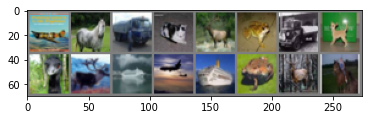

plane horse truck   cat  deer  frog truck   dog  bird  deer  ship plane  ship  frog  deer horse


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    ##########################################################################################
    #   Il faut transposée les images car PyTorch lis les image en [Chanels, Width, Height]  #
    #   et pour les voir il faut qu'elles soient [Width, Height, Chanels]                    #
    ##########################################################################################
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(16)))

### Création d'un CNN simple avec 2 couches de convolutions

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.fc1 = nn.Linear(in_features=20 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20 * 5 * 5) #flattening
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### Definition de la fonction Loss et de l'optimizeur

Exemple ici : Classification Cross-Entropy loss et SGD avec momentum.

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

### Entraînement du reseau


In [7]:
###############################################
#   * Fixer les paramètres de l'entraînement   #
###############################################
  
nb_epoch = 100 # Le nombre d'epoch
loss_list = [] # liste qui va contenir la valeur du loss a chaque epoch
accuracy_list = []
for epoch in range(nb_epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    nb_data = 0.
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)              # Forward
        loss = criterion(outputs, labels)
        loss.backward()                    # Backward
        optimizer.step()                   # optimize
 
        # print statistics
        running_loss += loss.item()
        
        nb_data += 1.
        
    running_loss = running_loss / nb_data
    loss_list.append(running_loss)  
    
    correct = 0.
    total = 0.
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy_list.append(correct / total)
    
    print("Epoch ", epoch, "; train loss = ", running_loss, "; accuracy = ", correct / total) 
    
torch.save({
                'nb_epoch': nb_epoch,
                'model' : net.state_dict(),
                'listLoss': loss_list,
            }, "modelNN.pth")

print('Finished Training and save the model as `modelNN.pth`')

Epoch  0 ; train loss =  1.0309346487617492 ; accuracy =  0.5712
Epoch  1 ; train loss =  1.0413881728172303 ; accuracy =  0.5742
Epoch  2 ; train loss =  1.0429740548539161 ; accuracy =  0.5616
Epoch  3 ; train loss =  1.070006279759407 ; accuracy =  0.5377
Epoch  4 ; train loss =  1.0458337939858438 ; accuracy =  0.5978
Epoch  5 ; train loss =  1.063083839058876 ; accuracy =  0.5774
Epoch  6 ; train loss =  1.0501775427389144 ; accuracy =  0.565
Epoch  7 ; train loss =  1.076967012424469 ; accuracy =  0.5686
Epoch  8 ; train loss =  1.1048963649463655 ; accuracy =  0.588
Epoch  9 ; train loss =  1.093283351354599 ; accuracy =  0.5713
Epoch  10 ; train loss =  1.0854895767855643 ; accuracy =  0.5687
Epoch  11 ; train loss =  1.0975661896944047 ; accuracy =  0.5808
Epoch  12 ; train loss =  1.1453356191849708 ; accuracy =  0.5113
Epoch  13 ; train loss =  1.1417723720359803 ; accuracy =  0.5623
Epoch  14 ; train loss =  1.1556938442850113 ; accuracy =  0.561
Epoch  15 ; train loss =  1

KeyboardInterrupt: ignored

### Tracer la courbe du loss

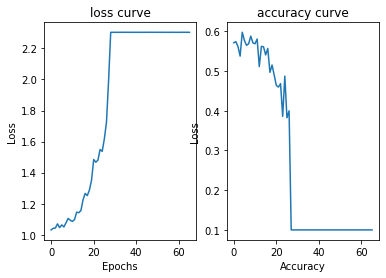

In [8]:
plt.subplot(1,2,1)
plt.plot(range(len(loss_list)), loss_list)

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("loss curve")

plt.subplot(1,2,2)
plt.plot(range(len(accuracy_list)), accuracy_list)

plt.xlabel("Accuracy")
plt.ylabel("Loss")
plt.title("accuracy curve")


plt.show()

### Tester le modèle sur les données de test

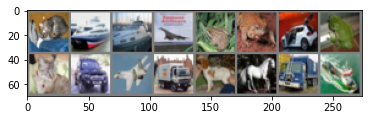

GroundTruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car plane truck   dog horse truck  ship
Predicted:    cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat   cat


In [9]:
# Charger un batch de l'ensemble de test
dataiter = iter(testloader)
images, labels = dataiter.next()

# Passer le batch dans le reseau
outputs = net(images)
predicted1 = torch.softmax(outputs.data, 1) #decision probabiliste (floue)

_, predicted2 = torch.max(predicted1, 1) #decision dure (classification)


# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(16)))
print('Predicted: ', ' '.join('%5s' % classes[predicted2[j]] for j in range(16)))

## Evaluation du modèle

### Taux de reconnaissance global

In [10]:
correct = 0.
total = 0.
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % ( 100. * correct / total))

Accuracy of the network on the 10000 test images: 10.000000 %


### Taux de reconnaissance de chacune des classes

In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %f %%' % (classes[i], 100. * class_correct[i] / class_total[i]))

Accuracy of plane : 0.000000 %
Accuracy of   car : 0.000000 %
Accuracy of  bird : 0.000000 %
Accuracy of   cat : 100.000000 %
Accuracy of  deer : 0.000000 %
Accuracy of   dog : 0.000000 %
Accuracy of  frog : 0.000000 %
Accuracy of horse : 0.000000 %
Accuracy of  ship : 0.000000 %
Accuracy of truck : 0.000000 %


## Exercices - A vous de jouer ...
* 1) Essayer de faire varier le nombre d'epochs pour améliorer la capacité du réseau à discriminer les différentes catégories d'images. Quel est le nombre d'epochs optimal ?

* 2) Pour ne pas tomber dans un phénomène de sur-apprentissage, modifier le code donné ci-dessus pour intégrer un ensemble de validation qui permet de déterminer les hyper-paramètres du réseau et notamment un nombre d'epochs adapté. 

* 3) Essayer de modifier l'architecture du réseau pour améliorer le taux de reconnaissance de ce dernier. Vous devez faire attention au nombre de filtres utilisés et à la dimension des données de sortie.

* 4) Proposer une interface permettant de visualiser les sorties des filtres de la première couche.

* 5) Refaire cet exercice en utilisant un autre réseau comme SqueezeNet déjà pré-entrainé sur ImageNet que vous affiner (fine-tuning) sur les classes de CIFAR10.

# Ajout d'un ensemble de validation

In [8]:
from torch.utils.data import random_split
val_size = 5000
train_size = len(trainset) - val_size

train_data, val_data = random_split(trainset, [train_size, val_size])
len(train_data), len(val_data)

(45000, 5000)

**Question 1 :** C'est clair que l'accuracy ne dépasse pas le 50% après 50 epoch donc le nombre optimal est 50 

In [9]:
from torch.utils.data.dataloader import DataLoader

batch_size=64
dl_train = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory=True)
dl_valid = DataLoader(val_data, batch_size, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))





# Modification de l'architecture du réseau

## **Définition des fonctions train et validation**

In [10]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
from os import device_encoding
def accuracy(outputs, labels):

    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class classificationModel(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        out,labels = out.to(device),labels.to(device)
        loss = F.cross_entropy(out, labels) # Calculate loss
        accu = accuracy(out,labels)
        return loss,accu
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'Loss': loss.detach(), 'Accuracy': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['Loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['Accuracy'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'Loss': epoch_loss.item(), 'Accuracy': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch :",epoch + 1)
        print(f'Train Accuracy:{result["train_accuracy"]*100:.2f}% Validation Accuracy:{result["Accuracy"]*100:.2f}%')
        print(f'Train Loss:{result["train_loss"]:.4f} Validation Loss:{result["Loss"]:.4f}')


## **Model pour CIFAR 10**

In [12]:
class Cifar10CnnModel(classificationModel):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)


In [13]:
@torch.no_grad()
def evaluate(model, data_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in data_loader]
    return model.validation_epoch_end(outputs)

def train_loop(model, train_loader, val_loader,epochs=10,learning_rate=0.001):
    best_valid = None
    trace_log = []
    optimizer = torch.optim.Adam(model.parameters(), learning_rate,weight_decay=0.0005)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accuracy = []
        for batch in tqdm(train_loader):
            loss,accu = model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(accu)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracy).mean().item()
        model.epoch_end(epoch, result)
        if(best_valid == None or best_valid<result['Accuracy']):
            best_valid=result['Accuracy']
            torch.save(model.state_dict(), 'cifar10-cnn.pth')
        trace_log.append(result)
    return trace_log

In [14]:
device = torch.device("cuda")
train_loader = DeviceDataLoader(dl_train, device)
val_loader = DeviceDataLoader(dl_valid, device)
test_loader = DeviceDataLoader(testloader, device)




In [67]:
model = to_device(Cifar10CnnModel(),device)
trace_log = train_loop(model, train_loader, val_loader)

  0%|          | 0/704 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 704/704 [00:39<00:00, 17.73it/s]


Epoch : 1
Train Accuracy:58.48% Validation Accuracy:68.51%
Train Loss:1.1705 Validation Loss:0.9519


100%|██████████| 704/704 [00:40<00:00, 17.48it/s]


Epoch : 2
Train Accuracy:74.11% Validation Accuracy:74.66%
Train Loss:0.7482 Validation Loss:0.7174


100%|██████████| 704/704 [00:39<00:00, 17.62it/s]


Epoch : 3
Train Accuracy:79.75% Validation Accuracy:78.28%
Train Loss:0.5945 Validation Loss:0.6256


100%|██████████| 704/704 [00:39<00:00, 17.65it/s]


Epoch : 4
Train Accuracy:82.55% Validation Accuracy:79.59%
Train Loss:0.5082 Validation Loss:0.6102


100%|██████████| 704/704 [00:39<00:00, 17.61it/s]


Epoch : 5
Train Accuracy:85.14% Validation Accuracy:80.24%
Train Loss:0.4371 Validation Loss:0.5979


100%|██████████| 704/704 [00:39<00:00, 17.65it/s]


Epoch : 6
Train Accuracy:87.14% Validation Accuracy:80.91%
Train Loss:0.3761 Validation Loss:0.5813


100%|██████████| 704/704 [00:39<00:00, 17.71it/s]


Epoch : 7
Train Accuracy:88.09% Validation Accuracy:83.33%
Train Loss:0.3464 Validation Loss:0.5189


100%|██████████| 704/704 [00:39<00:00, 17.62it/s]


Epoch : 8
Train Accuracy:89.78% Validation Accuracy:83.19%
Train Loss:0.2962 Validation Loss:0.5071


100%|██████████| 704/704 [00:39<00:00, 17.73it/s]


Epoch : 9
Train Accuracy:91.04% Validation Accuracy:82.44%
Train Loss:0.2597 Validation Loss:0.5530


100%|██████████| 704/704 [00:39<00:00, 17.78it/s]


Epoch : 10
Train Accuracy:91.58% Validation Accuracy:83.01%
Train Loss:0.2376 Validation Loss:0.5600


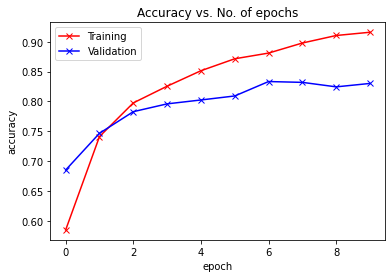

In [68]:
def plot_accuracies(trace_log):
    Validation_accuracies = [x['Accuracy'] for x in trace_log]
    Training_Accuracies = [x['train_accuracy'] for x in trace_log]
    plt.plot(Training_Accuracies, '-rx')
    plt.plot(Validation_accuracies, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Training', 'Validation'])
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(trace_log)

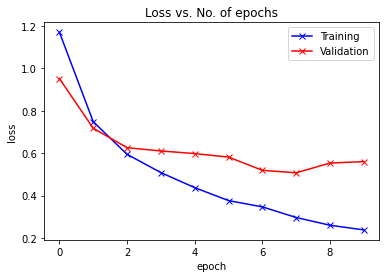

In [69]:
def plot_losses(trace_log):
    train_losses = [x.get('train_loss') for x in trace_log]
    val_losses = [x['Loss'] for x in trace_log]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(trace_log)

In [73]:
result = evaluate(model, test_loader)
print(f'Test Accuracy:{result["Accuracy"]*100:.2f}%')

Test Accuracy:82.62%


**Test accuracy  82.6 %**


# Utilisation d'un modele pré entrainé VGG 16

In [48]:
model = models.vgg16(pretrained = True)
input_lastLayer = model.classifier[6].in_features
model.classifier[6] = nn.Linear(input_lastLayer,10)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum=0.9,weight_decay=5e-4)
n_total_step = len(train_loader)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [49]:
for epoch in range(10):
    for i, (imgs , labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        labels_hat = model(imgs)
        n_corrects = (labels_hat.argmax(axis=1)==labels).sum().item()
        loss_value = criterion(labels_hat, labels)
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
        if (i+1) % 250 == 0:
           print(f'epoch {epoch+1}/{10}, step: {i+1}/{n_total_step}: loss = {loss_value:.5f}, acc = {100*(n_corrects/labels.size(0)):.2f}%')
    print()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1/10, step: 250/704: loss = 0.47684, acc = 82.81%
epoch 1/10, step: 500/704: loss = 0.64107, acc = 78.12%

epoch 2/10, step: 250/704: loss = 0.37326, acc = 90.62%
epoch 2/10, step: 500/704: loss = 0.40202, acc = 85.94%

epoch 3/10, step: 250/704: loss = 0.33086, acc = 85.94%
epoch 3/10, step: 500/704: loss = 0.30415, acc = 92.19%

epoch 4/10, step: 250/704: loss = 0.18730, acc = 95.31%
epoch 4/10, step: 500/704: loss = 0.32026, acc = 89.06%

epoch 5/10, step: 250/704: loss = 0.16960, acc = 92.19%
epoch 5/10, step: 500/704: loss = 0.18188, acc = 95.31%

epoch 6/10, step: 250/704: loss = 0.09794, acc = 95.31%
epoch 6/10, step: 500/704: loss = 0.03183, acc = 100.00%

epoch 7/10, step: 250/704: loss = 0.16024, acc = 95.31%
epoch 7/10, step: 500/704: loss = 0.11156, acc = 96.88%

epoch 8/10, step: 250/704: loss = 0.02595, acc = 100.00%
epoch 8/10, step: 500/704: loss = 0.03647, acc = 100.00%

epoch 9/10, step: 250/704: loss = 0.06721, acc = 98.44%
epoch 9/10, step: 500/704: loss = 0.1

In [50]:
with torch.no_grad():
    number_corrects = 0
    number_samples = 0
    for i, (test_images_set , test_labels_set) in enumerate(test_loader):
        test_images_set = test_images_set.to(device)
        test_labels_set = test_labels_set.to(device)
    
        y_predicted = model(test_images_set)
        labels_predicted = y_predicted.argmax(axis = 1)
        number_corrects += (labels_predicted==test_labels_set).sum().item()
        number_samples += test_labels_set.size(0)
    print(f'Overall accuracy {(number_corrects / number_samples)*100}%')

Overall accuracy 87.03999999999999%


**Test accuracy avec VGG prentrainé 87 %**


# Visualiasation d'un feature map du premier filtre de convolution

**J'ai recontré des problèmes en essayant avec le cifar 10 et le reseau CIFAR10 utilisé ci-dessus alors j'ai utilisé MNIST et un autre réseau juste pour démonstration**

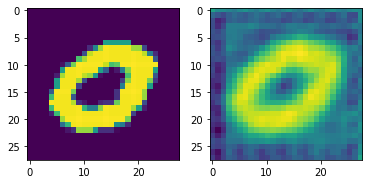

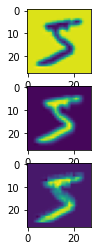

In [55]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(3, 6, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv_trans1 = nn.ConvTranspose2d(6, 3, 4, 2, 1)
        self.conv_trans2 = nn.ConvTranspose2d(3, 1, 4, 2, 1)
        
    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))        
        x = F.relu(self.conv_trans1(x))
        x = self.conv_trans2(x)
        return x

dataset =torchvision.datasets.MNIST(
    root='./data',
    download=True,
    transform=transforms.ToTensor()
)
loader = DataLoader(
    dataset,
    num_workers=2,
    batch_size=8,
    shuffle=True
)

model = MyModel()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 1
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        
      


def normalize_output(img):
    img = img - img.min()
    img = img / img.max()
    return img

# Plot some images
idx = torch.randint(0, output.size(0), ())
pred = normalize_output(output[idx, 0])
img = data[idx, 0]

fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(img.detach().numpy())
axarr[1].imshow(pred.detach().numpy())

# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))
data, _ = dataset[0]
data.unsqueeze_(0)
output = model(data)

act = activation['conv1'].squeeze()
fig, axarr = plt.subplots(act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])